# Hyper-Palatable Foods (HPF) Food product clustering

Goal:
    
Use a subset of columns from the nutrient matrix created in a previous notebook and calculate the following variables:
* PFAT: Percent calories (kilocalories) from fat
* PSUGR: Percent calories (kilocalories) from simple sugars
* PCARB: Percent calories (kilocalories) from carbohydrates
* PSODI: Percent sodium by food weight (in grams) per portion

Using the variables, calculate if each USDA food product satisfies the conditions to fall into any of the three different HPF clusters: 

1) FSOD: Fat and Sodium (>25% kcal from fat, ≥0.30% sodium by weight)
2) FS: Fat and Simple Sugars (>20% kcal from fat,>20% kcal from sugar)
3) CSOD: Carbohydrates and Sodium (>40% kcal from carbohydrates, ≥0.20% sodium by weight)

A food product can exist in one, all or none. If a food doesn't fall into any of these clusters, it is possible the food is not hyper palatable. True/False columns will be returned for each cluster. The methods for this notebook follow directly from the 2019 article [Hyper-Palatable Foods: Development of a Quantitative Definition and Application to the US Food System Database](https://www.researchgate.net/publication/337039170_Hyper-Palatable_Foods_Development_of_a_Quantitative_Definition_and_Application_to_the_US_Food_System_Database).


Misc resources:
* https://github.com/USDA/USDA-APIs/issues/120

## Setup

In [16]:
import numpy as np
import pandas as pd
import sqlalchemy as sal

from sqlalchemy import text

In [54]:
nutrient_matrix_data_p = r"../../data/"

nutrient_matrix_csv_p = nutrient_matrix_data_p + "nutrients_matrix.csv.gz"

nutrient_matrix_nutriscore_p = nutrient_matrix_data_p + "usda_2022_nutri_score.csv.gz"

nutrient_matrix_hpf_component_p = nutrient_matrix_data_p + "usda_2022_hpf_component.csv.gz"

#### Import the data cleaned in a previous notebook. Set the fdc_id to the index.

In [18]:
nutrients_matrix = pd.read_csv(nutrient_matrix_csv_p)
nutrients_matrix.set_index("fdc_id", inplace = True)
print(nutrients_matrix.shape)
nutrients_matrix.head()

(1590701, 103)


,1003,1004,1005,1008,1079,1082,1084,1087,1089,1092,...,1099,1196,1316,1233,1112,1111,1273,1236,1080,1068
fdc_id,,,,,,,,,,,,,,,,,,,,,
344604,0.81,0.41,4.07,24.0,0.8,0.0,0.0,13.0,0.00,179.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344605,0.81,0.41,4.07,24.0,0.8,0.0,0.0,16.0,0.00,179.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344606,23.21,2.68,0.00,0.0,0.0,0.0,0.0,0.0,1.29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344607,23.21,2.68,0.00,0.0,0.0,0.0,0.0,0.0,1.29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344608,18.75,15.18,0.00,0.0,0.0,0.0,0.0,18.0,0.96,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Choose a subset of the nutrients

The measurements of fat, simple sugars, carbohydrates, and sodium were the focuses of the analyses. The following assumptions were made:

* [Main Article](https://www.researchgate.net/publication/337039170_Hyper-Palatable_Foods_Development_of_a_Quantitative_Definition_and_Application_to_the_US_Food_System_Database):
    - "Percent calories (kilocalories) from fat (PFAT), simple sugars (PSUGR), and carbohydrates (PCARB) per serving was calculated using standard values of 9 kcal/g for fat and 4 kcal/g for carbohydrates and simple sugars (46). Percent kilocalories from carbohydrates was calculated from a total carbohydrates variable, which included fiber. Fiber slows the process of absorption of carbohydrates and sugar into the system, enhances satiety, and can alter palatability and food texture (47). Therefore, we subtracted fiber before calculating percent kilocalories from carbohydrates. To avoid overlap between the carbohydrates and simple sugars variables, we also subtracted sugar before calculating percent kilocalories from carbohydrates. The total sugars variable, which  consisted of  both  naturally  occurring  and  added  sugars, was used to calculate percent kilocalories from simple sugars. For sodium, percent sodium  by food  weight (PSODI) (in grams) per portion was calculated"

* [FoodData Central documentation](https://fdc.nal.usda.gov/data-documentation.html)):
    - For calories, Atwater General Factors of 4, 9, and 4 for protein, fat and carbohydrate, respectively are used to calculated total energy in kcal.
    - "Carbohydrate content, referred to as “carbohydrate by difference” in the tables, is expressed as the difference between 100 and the sum of the percentages of water, protein, total lipid (fat), ash, and alcohol (when present)." Documentation for foundation foods: "Values for carbohydrate by difference include total dietary fiber content. "

Variables

* Fat: Use Total Lipid (Fat)
* Simple Sugar: Use 'SUGARS, TOTAL'. "The total sugars variable, which  consisted of  both  naturally  occurring  and  added  sugars,  was used to calculate percent kilocalories from simple sugars."
* Carbohydrate: Use 'CARBOHYDRATE, BY DIFFERENCE', subtract 'FIBER, TOTAL DIETARY' and 'SUGARS, TOTAL'
* Use: 'SODIUM, NA'. Divide by 1000 to convert mg to grams.

In [19]:
subset = ['ENERGY', 'TOTAL LIPID (FAT)', 'SUGARS, TOTAL', 'CARBOHYDRATE, BY DIFFERENCE', 'FIBER, TOTAL DIETARY', 'SODIUM, NA']

#### Get the list of nutrient names from nourish

In [20]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [21]:
nourish_user = "gmichael"

nourish_pswd = "567khcwx3s"

engine = sal.create_engine('postgresql+psycopg2://' + nourish_user + ':' + nourish_pswd + '@awesome-hw.sdsc.edu/nourish')
conn = engine.connect()

In [22]:
query_nutrients = text('''SELECT *
from "usda_2022_nutrient_master"''')

result = conn.execute(query_nutrients)

nutrient_names = [i for i in result]

nutrient_names[0:2]

[(2047, 'Energy (Atwater General Factors)', 'KCAL', Decimal('957'), '280.0'),
 (2048, 'Energy (Atwater Specific Factors)', 'KCAL', Decimal('958'), '290.0')]

In [23]:
nutrient_names_df = pd.DataFrame(nutrient_names)
nutrient_names_df['name'] = nutrient_names_df['name'].str.upper()
nutrient_names_df[nutrient_names_df['name'].isin(subset)]

,id,name,unit_name,nutrient_nbr,rank
5,1004,TOTAL LIPID (FAT),G,204,800.0
6,1005,"CARBOHYDRATE, BY DIFFERENCE",G,205,1110.0
9,1008,ENERGY,KCAL,208,300.0
63,1062,ENERGY,kJ,268,400.0
80,1079,"FIBER, TOTAL DIETARY",G,291,1200.0
94,1093,"SODIUM, NA",MG,307,5800.0
415,2000,"SUGARS, TOTAL",G,269,1510.0


#### Combine kj and kcal energy components into kcal only

In [24]:
nutrients_matrix['1062'] = nutrients_matrix['1062']/4.184 #1 kcal is 4.184 kj
nutrients_matrix['1008'] = nutrients_matrix['1008'] + nutrients_matrix['1062']
del nutrients_matrix['1062']

#### Update the matrix column headers

In [25]:
var_mapping = {}
for col in nutrients_matrix.columns:
    var_mapping[col] = nutrient_names_df[nutrient_names_df['id']==int(col)].iloc[0]['name']
    
nutrients_matrix.rename(columns = var_mapping, inplace = True)

#### Choose a subset of the nutrients

In [26]:
nutrients_matrix = nutrients_matrix[subset]
nutrients_matrix

,ENERGY,TOTAL LIPID (FAT),"SUGARS, TOTAL","CARBOHYDRATE, BY DIFFERENCE","FIBER, TOTAL DIETARY","SODIUM, NA"
fdc_id,,,,,,
344604,24.0,0.41,2.44,4.07,0.8,203.0
344605,24.0,0.41,2.44,4.07,0.8,203.0
344606,0.0,2.68,0.00,0.00,0.0,67.0
344607,0.0,2.68,0.00,0.00,0.0,67.0
344608,0.0,15.18,0.00,0.00,0.0,103.0
...,...,...,...,...,...,...
2340755,67.0,1.82,2.73,7.58,0.6,48.0
2340756,67.0,1.82,2.73,7.58,0.6,58.0
2340757,67.0,1.82,2.73,7.58,0.6,58.0


### Augment columns

#### Convert Sodium MG to G

In [27]:
nutrients_matrix['SODIUM, NA'] = nutrients_matrix['SODIUM, NA'] / 1000 #divide by 1000 to convert mg to g

#### Calculate carbohydrate

In [31]:
nutrients_matrix['CARBOHYDRATE'] = (nutrients_matrix['CARBOHYDRATE, BY DIFFERENCE'] - nutrients_matrix['FIBER, TOTAL DIETARY'] 
                                    - nutrients_matrix['SUGARS, TOTAL'])

nutrients_matrix.drop(columns = ['CARBOHYDRATE, BY DIFFERENCE', 'FIBER, TOTAL DIETARY'], inplace = True)

#### Convert Fat, Sugar and carbs to kcal

In [32]:
nutrients_matrix['TOTAL LIPID (FAT)'] = nutrients_matrix['TOTAL LIPID (FAT)'] * 9
nutrients_matrix['SUGARS, TOTAL'] = nutrients_matrix['SUGARS, TOTAL'] * 4
nutrients_matrix['CARBOHYDRATE'] = nutrients_matrix['CARBOHYDRATE'] * 4
nutrients_matrix

,ENERGY,TOTAL LIPID (FAT),"SUGARS, TOTAL","SODIUM, NA",CARBOHYDRATE
fdc_id,,,,,
344604,24.0,3.69,9.76,0.203,3.32
344605,24.0,3.69,9.76,0.203,3.32
344606,0.0,24.12,0.00,0.067,0.00
344607,0.0,24.12,0.00,0.067,0.00
344608,0.0,136.62,0.00,0.103,0.00
...,...,...,...,...,...
2340755,67.0,16.38,10.92,0.048,17.00
2340756,67.0,16.38,10.92,0.058,17.00
2340757,67.0,16.38,10.92,0.058,17.00


### Calculate clusters

#### Calculate PFAT, PSUGAR, PCARB and PSODI

In [35]:
nutrients_matrix['PFAT'] = nutrients_matrix['TOTAL LIPID (FAT)']/nutrients_matrix['ENERGY']
nutrients_matrix['PSUGAR'] = nutrients_matrix['SUGARS, TOTAL']/nutrients_matrix['ENERGY']
nutrients_matrix['PCARB'] = nutrients_matrix['CARBOHYDRATE']/nutrients_matrix['ENERGY']
nutrients_matrix.rename(columns = {'SODIUM, NA': 'PSODI'}, inplace = True)

In [39]:
nutrients_matrix.fillna(0, inplace = True)
nutrients_matrix.replace([np.inf, -np.inf], 0, inplace=True)
nutrients_matrix.drop(columns = ['ENERGY', 'TOTAL LIPID (FAT)', 'SUGARS, TOTAL', 'CARBOHYDRATE'], inplace = True)
nutrients_matrix

,PSODI,PSUGAR,PCARB,PFAT
fdc_id,,,,
344604,0.203,0.406667,0.138333,0.153750
344605,0.203,0.406667,0.138333,0.153750
344606,0.067,0.000000,0.000000,0.000000
344607,0.067,0.000000,0.000000,0.000000
344608,0.103,0.000000,0.000000,0.000000
...,...,...,...,...
2340755,0.048,0.162985,0.253731,0.244478
2340756,0.058,0.162985,0.253731,0.244478
2340757,0.058,0.162985,0.253731,0.244478


### Calculate FSOD, FS and CSOD
Sodium is per 100g, so 0.3% is just 0.3

In [48]:
nutrients_matrix['FSOD'] = ((nutrients_matrix['PFAT']>0.25) & (nutrients_matrix['PSODI']>=0.30))
nutrients_matrix['FS'] = ((nutrients_matrix['PFAT']>0.20) & (nutrients_matrix['PSUGAR']>0.20))
nutrients_matrix['CSOD'] = ((nutrients_matrix['PCARB']>0.40) & (nutrients_matrix['PSODI']>=0.20))
nutrients_matrix.drop(columns = ['PSODI', 'PSUGAR', 'PCARB', 'PFAT'], inplace = True)

In [50]:
nutrients_matrix.sum()

FSOD    443729
FS      304644
CSOD    221936
dtype: int64

In [51]:
nutrients_matrix

,FSOD,FS,CSOD
fdc_id,,,
344604,False,False,False
344605,False,False,False
344606,False,False,False
344607,False,False,False
344608,False,False,False
...,...,...,...
2340755,False,False,False
2340756,False,False,False
2340757,False,False,False


Export results

In [52]:
nutrients_matrix.to_csv(nutrient_matrix_hpf_component_p, 
                   index = True, compression = "gzip")

### Extra: Compare with Nutri-Score

In [55]:
nutri_score_df = pd.read_csv(nutrient_matrix_nutriscore_p)
nutri_score_df.set_index("fdc_id", inplace = True)
print(nutri_score_df.shape)
nutri_score_df.head()

(1590701, 2)


,nutri_score,nutri_score_label
fdc_id,,
344604,0.0,B
344605,0.0,B
344606,-5.0,A
344607,-5.0,A
344608,0.0,B


In [57]:
combined_scores = nutrients_matrix.merge(nutri_score_df, left_index = True, right_index = True)
combined_scores

,FSOD,FS,CSOD,nutri_score,nutri_score_label
fdc_id,,,,,
344604,False,False,False,0.0,B
344605,False,False,False,0.0,B
344606,False,False,False,-5.0,A
344607,False,False,False,-5.0,A
344608,False,False,False,0.0,B
...,...,...,...,...,...
2340755,False,False,False,-4.0,A
2340756,False,False,False,-4.0,A
2340757,False,False,False,-4.0,A


In [63]:
import seaborn as sns

Use mean to get the % true

<Axes: ylabel='nutri_score_label'>

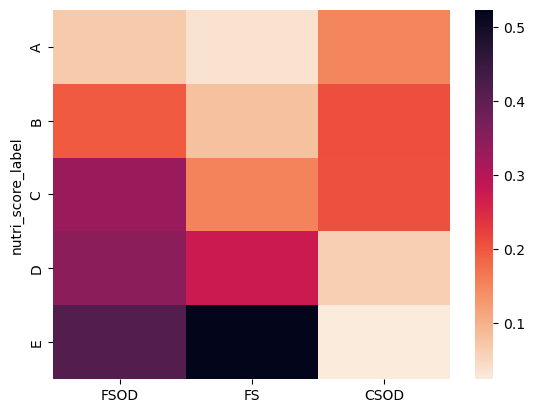

In [70]:
sns.heatmap(combined_scores.groupby(by = "nutri_score_label")[["FSOD", "FS", "CSOD"]].mean(), cmap = "rocket_r")

In [71]:
combined_scores[(combined_scores['CSOD'] == True) & (combined_scores['nutri_score_label'] == 'A')]

,FSOD,FS,CSOD,nutri_score,nutri_score_label
fdc_id,,,,,
345819,False,False,True,-1.0,A
345844,False,False,True,-1.0,A
345845,False,False,True,-1.0,A
346438,False,False,True,-1.0,A
348222,False,False,True,-2.0,A
...,...,...,...,...,...
2340460,False,False,True,-1.0,A
2340493,False,False,True,-3.0,A
2340522,False,False,True,-1.0,A
